In [1]:
import os
import csv
import glob
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
%matplotlib inline

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def read_csv(csv_ffn):
    columns = []
    with open(csv_ffn,'r') as f: 
        reader = csv.reader(f)
        for row in reader:
            if columns:
                for i, value in enumerate(row):
                    columns[i].append(value.rstrip())
            else:
                # first row
                columns = [[value] for value in row]
    # you now have a column-major 2D array of your file.
    as_dict = {c[0] : c[1:] for c in columns}
    return as_dict

In [3]:
def plot_mesoanalysis(name, lat, lon, wspd, wdir, temp, dwpt, mslp):
    
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)

    #wind barbs data
    if not math.isnan(wspd):
        wspd = wspd*0.277778*2 #to convert km/h to m/s and doubled
        wdir = (270-wdir)*0.0174533 #convert compass degrees to radians
        uwnd = wspd*np.cos(wdir)
        vwnd = wspd*np.sin(wdir)
        ax.barbs(lon, lat, uwnd, vwnd, flip_barb=True)    
    
    #thermo data
    if not math.isnan(temp):
        temp_transform = offset_copy(geodetic_transform, units='dots', x=-5, y=20)
        dwpt_transform = offset_copy(geodetic_transform, units='dots', x=-5, y=-20)
        temp_str = str(int(round(temp)))
        dwpt_str = str(int(round(dwpt)))
        plt.text(lon, lat, temp_str,
                 verticalalignment='center', horizontalalignment='right',
                 transform=temp_transform, color='k', fontsize=9)
        plt.text(lon, lat, dwpt_str,
                 verticalalignment='center', horizontalalignment='right',
                 transform=dwpt_transform, color='k', fontsize=9)

    #pres data    
    if not math.isnan(mslp):
        mslp_transform = offset_copy(geodetic_transform, units='dots', x= 5, y=-20)
        mslp_str = str(int(round(mslp*10)))[-3:]
        plt.text(lon, lat, mslp_str,
                 verticalalignment='center', horizontalalignment='left',
                 transform=mslp_transform, color='k', fontsize=9)
        
    #name
    name_transform = offset_copy(geodetic_transform, units='dots', x= 5, y=20)
    plt.text(lon, lat, name,
             verticalalignment='center', horizontalalignment='left',
             transform=name_transform, color='k', fontsize=9)

In [4]:
def plot_radar(radar, ax):
    #plot radar
    display    = pyart.graph.RadarMapDisplayCartopy(radar)
    gatefilter = pyart.correct.GateFilter(radar)
    gatefilter.exclude_below('DBZH', rmin)
    display.plot_ppi_map(field='DBZH', sweep=sweep, ax=ax, gatefilter=gatefilter, embelish=False, vmin=rmin, vmax=rmax, cmap=cmap)
    del display # Release memory

In [5]:
def convert_slist_to_array(mylist):
    out = np.array([])
    for item in mylist:
        try:
            val = float(item)
        except:
            val = np.nan
        out = np.append(out, val)
    return out

In [6]:
from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

processing  /g/data1a/kl02/jss548/20161113_case/radar/66_20161113_073035.pvol.h5
<generator object Reader.geometries at 0x7fc210ff5e60>
processing 2016-11-13 07:30:35


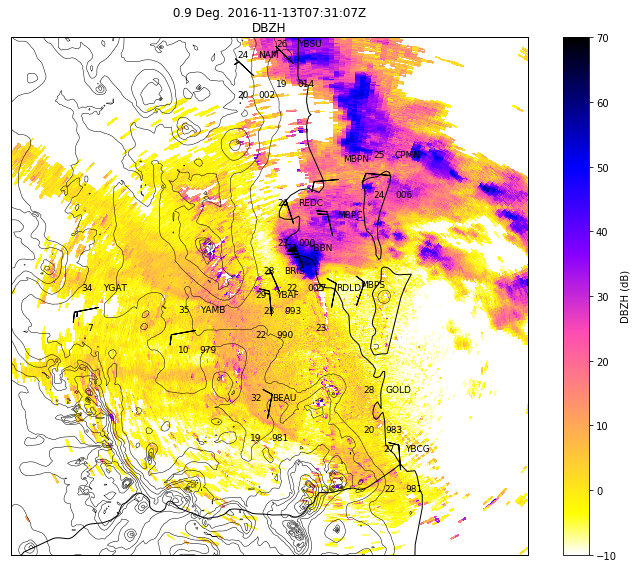

In [7]:
#init
plt_limits    = [152, 154, -28.5, -26.5]
m_lat         = [-27.466, -27.983]
m_lon         = [153.033, 152.983]
m_name        = ['BN',    'BD']
aws_skip_list = ['GYM', 'YMYB', 'YHBA', 'YDLP', 'TEW','YKRY']
sweep         = 1
rmin          = -10
rmax          = 70
cmap          = 'gnuplot2_r'
#paths
aws_data_ffn = '/g/data1a/kl02/jss548/20161113_case/aws/20161113_seq_1min_aws.txt'
radar_path   = '/g/data1a/kl02/jss548/20161113_case/radar'
img_out_path = '/g/data1a/kl02/jss548/20161113_case/meso_img'
shape_fn     = '/g/data1a/kl02/jss548/20161113_case/srtm_contours/seq_topo_200m_200steps.shp'

#read aws data
aws_dict = read_csv(aws_data_ffn)
#parse data
aws_dts  = aws_dict['UTC']
aws_name = aws_dict['Aviation ID']
aws_lat  = convert_slist_to_array(aws_dict['Latitude'])
aws_lon  = convert_slist_to_array(aws_dict['Longitude'])
aws_temp = convert_slist_to_array(aws_dict['Temp(C)'])
aws_dwpt = convert_slist_to_array(aws_dict['Dp(C)'])
aws_wspd = convert_slist_to_array(aws_dict['WSpd(km/h)'])
aws_wdir = convert_slist_to_array(aws_dict['WDir(deg)'])
aws_mslp = convert_slist_to_array(aws_dict['MSLP'])
#generate aws datetime number
aws_dt  = [datetime.strptime(dts, '%Y%m%d%H%M') for dts in aws_dts]

#read radar data
radar_file_list = sorted(glob.glob(radar_path + '/*.pvol.h5'))

for radar_file in radar_file_list:
    print('processing ', radar_file)
    
    #init figure
    fig = plt.figure(figsize=(10, 8), facecolor='w')
    #subplot map
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent(plt_limits, ccrs.PlateCarree())
    #ax.coastlines(resolution='10m', edgecolor='gray')
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='10m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='k', linewidth=1.0)
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                                facecolor='none', name='coastline')
    ax.add_feature(coast, edgecolor='k', linewidth=1.0)

    #load shapefile
    print(Reader(shape_fn).geometries())
    shape_feature = ShapelyFeature(Reader(shape_fn).geometries(),
                                    ccrs.PlateCarree(), facecolor='none')
    ax.add_feature(shape_feature, edgecolor='k', linewidth=0.5)
    
    #load radar data
    radar = pyart.aux_io.read_odim_h5(radar_file, file_field_names=True)
    radar.fields['DBZH']['units'] = 'dB'
    #extract radar time
    radar_time = datetime.strptime(radar.time['units'][14:-1], '%Y-%m-%dT%H:%M:%S')
    print('processing', radar_time)
    #find closest matching index of aws time
    aws_dt_match = min(aws_dt, key=lambda d: abs(d - radar_time))
    idx_list = [i for i, x in enumerate(aws_dt) if x == aws_dt_match]

    #plot on figure
    plot_radar(radar, ax)
    #plot_mesoanalysis()
    for idx in idx_list:
        if aws_name[idx] not in aws_skip_list:
            plot_mesoanalysis(aws_name[idx], aws_lat[idx],
                              aws_lon[idx], aws_wspd[idx], aws_wdir[idx],
                             aws_temp[idx], aws_dwpt[idx], aws_mslp[idx])

    #export image
    plt.tight_layout()
    out_fn  = '_'.join(['mesoanaly',radar_time.strftime('%Y%m%d_%H%M%S')]) + '.png'
    out_ffn = '/'.join([img_out_path, out_fn])
    plt.savefig(out_ffn, dpi=200)
    plt.show()
    
    #clear memory
    fig.clf()   # Clear figure
    plt.close()  # Release memory
    del radar   # Release memory